In [46]:
import os
import json
import gzip
import pandas as pd
from urllib.request import urlopen

In [47]:
!wget https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFiles/Industrial_and_Scientific.json.gz

--2023-11-07 17:24:03--  https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFiles/Industrial_and_Scientific.json.gz
Resolving datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)... 132.239.8.30
Connecting to datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 210409178 (201M) [application/x-gzip]
Saving to: ‘Industrial_and_Scientific.json.gz.1’

Industrial_and_Scie 100%[===================>] 200.66M  25.7MB/s    in 9.0s    

2023-11-07 17:24:12 (22.4 MB/s) - ‘Industrial_and_Scientific.json.gz.1’ saved [210409178/210409178]



In [48]:
!wget https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/metaFiles2/meta_Industrial_and_Scientific.json.gz

--2023-11-07 17:24:12--  https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/metaFiles2/meta_Industrial_and_Scientific.json.gz
Resolving datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)... 132.239.8.30
Connecting to datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 83600786 (80M) [application/x-gzip]
Saving to: ‘meta_Industrial_and_Scientific.json.gz.1’

meta_Industrial_and 100%[===================>]  79.73M  32.8MB/s    in 2.4s    

2023-11-07 17:24:15 (32.8 MB/s) - ‘meta_Industrial_and_Scientific.json.gz.1’ saved [83600786/83600786]



In [49]:
!pip install pyspark

# Data Reading

In [50]:
from pyspark.sql import SparkSession

# Create a Spark session
spark = SparkSession.builder \
    .appName("readGZ") \
    .master("local[*]") \
    .config("spark.default.parallelism", 2) \
    .config("spark.sql.shuffle.partitions", 2) \
    .getOrCreate()

# Read the gzipped JSON file directly into a DataFrame
df = spark.read.json("Industrial_and_Scientific.json.gz")

In [51]:
# Show the DataFrame to check if it's loaded correctly
df.show(10)

+----------+-----+-------+--------------------+-----------+--------------+----------------+-----+--------------------+--------------+--------+----+
|      asin|image|overall|          reviewText| reviewTime|    reviewerID|    reviewerName|style|             summary|unixReviewTime|verified|vote|
+----------+-----+-------+--------------------+-----------+--------------+----------------+-----+--------------------+--------------+--------+----+
|0176496920| NULL|    5.0|Arrived on time, ...|01 23, 2013|A3FANY5GOT5X0W|    Kelly Keyser| NULL|  Just as described!|    1358899200|    true|NULL|
|0176496920| NULL|    5.0|This device was h...| 11 5, 2012| AT6HRPPYOPHMB|       Michael C| NULL|        Great device|    1352073600|    true|NULL|
|0176496920| NULL|    4.0|Just a clicker no...|10 17, 2012| A4IX7B38LIN1E|              BH| NULL|         Pretty Good|    1350432000|    true|NULL|
|0176496920| NULL|    5.0|Great response ca...|03 29, 2017|A12Q4LR8N17AOZ|   Waterfall3500| NULL|Thank you for t

In [52]:
### load the meta data

df_meta = spark.read.json("meta_Industrial_and_Scientific.json.gz")

In [53]:
df_meta.show(10)

+--------------------+--------------------+----------+--------------------+--------------------+-----------------+--------------------+-------+--------------------+---+--------------------+--------------------+--------------------+------+--------------------+------------+--------------------+-----+--------------------+
|            also_buy|           also_view|      asin|               brand|            category|             date|         description|details|             feature|fit|            imageURL|     imageURLHighRes|            main_cat| price|                rank|similar_item|               tech1|tech2|               title|
+--------------------+--------------------+----------+--------------------+--------------------+-----------------+--------------------+-------+--------------------+---+--------------------+--------------------+--------------------+------+--------------------+------------+--------------------+-----+--------------------+
|[1454894547, 0133...|               

## Discussion



1.   We can not read some categories (especially those with large data, in this case, the sofrware category) directly in Spark; Need to figure out why and how to solve this. (Tried reading by in raw and use pandas and then spark, but this also failed.)
(I skipped this question by choosing another category which is fine to read directly)





# Data Pre-Processing and visulization

In [54]:
# Drop the image column because I don't think we need it
df = df.drop('image')

In [55]:
from pyspark.sql.functions import col, when, length, unix_timestamp, to_date

# Handling missing values: For simplicity, we'll drop rows with any NULLs
df = df.na.drop()

# Filtering out unverified reviews
df = df.filter(col('verified') == True)

# Feature Engineering - creating a new feature for the length of the reviewText
df = df.withColumn('reviewText_length', length(col('reviewText')))


In [56]:
# Show the processed DataFrame
df.show(10)

+----------+-------+--------------------+-----------+--------------+-------------+--------------------+--------------------+--------------+--------+----+-----------------+
|      asin|overall|          reviewText| reviewTime|    reviewerID| reviewerName|               style|             summary|unixReviewTime|verified|vote|reviewText_length|
+----------+-------+--------------------+-----------+--------------+-------------+--------------------+--------------------+--------------+--------+----+-----------------+
|1587790637|    5.0|I love everything...| 08 3, 2014| ALORN8T3UJC88| Ji Sung Moon|{NULL, NULL, NULL...|Great studying ma...|    1407024000|    true|   6|              390|
|1587790637|    2.0|Disappointed with...| 06 9, 2014|A2DR04A9BINUE6|        Becky|{NULL, NULL, NULL...|             Creased|    1402272000|    true|   4|              157|
|1587790637|    1.0|Very poor packagi...| 04 8, 2014|A39NP41GNG6DJT|  Nicole Ryan|{NULL, NULL, NULL...|Poster bent and w...|    1396915200| 

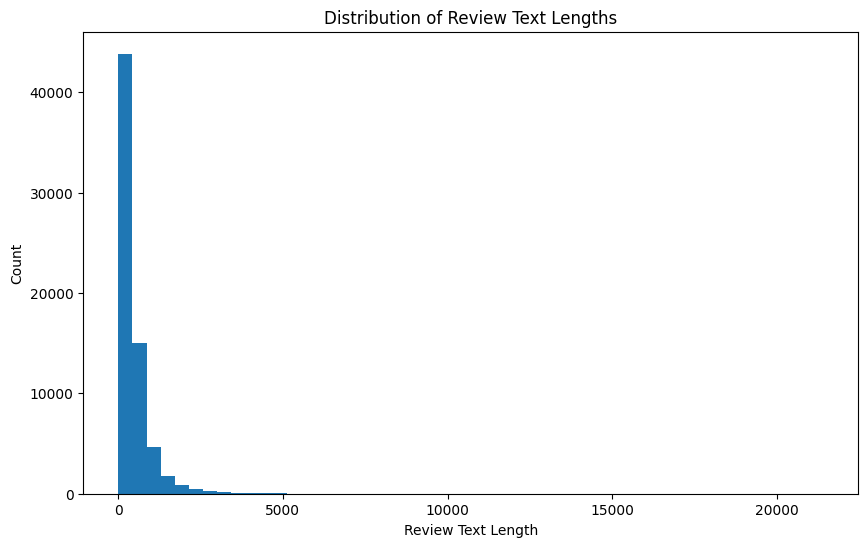

In [57]:
import matplotlib.pyplot as plt

review_lengths = df.select('reviewText_length').rdd.flatMap(lambda x: x).collect()

# Now convert this list to a Pandas Series
pd_series = pd.Series(review_lengths)

# Plotting the distribution of reviewText_length using Pandas/Matplotlib
plt.figure(figsize=(10, 6))
pd_series.hist(bins=50)  # Adjust the number of bins for your specific dataset
plt.title('Distribution of Review Text Lengths')
plt.xlabel('Review Text Length')
plt.ylabel('Count')
plt.grid(False)
plt.show()

In [58]:
# Example of filtering based on a condition, such as reviews that are too short/long might be outliers
df = df.filter(col('reviewText_length') > 10)  # Example threshold

df = df.filter(col('reviewText_length') < 1000)  # Example threshold

In [59]:
# Text Processing - cleaning the review text, tokenizing, and removing stop words (simplified example)
from pyspark.ml.feature import Tokenizer, StopWordsRemover
tokenizer = Tokenizer(inputCol='reviewText', outputCol='reviewText_tokens')
df = tokenizer.transform(df)
remover = StopWordsRemover(inputCol='reviewText_tokens', outputCol='reviewText_clean')
df = remover.transform(df)

In [60]:
# Show the processed DataFrame
df.show(10)

+----------+-------+--------------------+-----------+--------------+-------------+--------------------+--------------------+--------------+--------+----+-----------------+--------------------+--------------------+
|      asin|overall|          reviewText| reviewTime|    reviewerID| reviewerName|               style|             summary|unixReviewTime|verified|vote|reviewText_length|   reviewText_tokens|    reviewText_clean|
+----------+-------+--------------------+-----------+--------------+-------------+--------------------+--------------------+--------------+--------+----+-----------------+--------------------+--------------------+
|1587790637|    5.0|I love everything...| 08 3, 2014| ALORN8T3UJC88| Ji Sung Moon|{NULL, NULL, NULL...|Great studying ma...|    1407024000|    true|   6|              390|[i, love, everyth...|[love, everything...|
|1587790637|    2.0|Disappointed with...| 06 9, 2014|A2DR04A9BINUE6|        Becky|{NULL, NULL, NULL...|             Creased|    1402272000|    t

In [61]:
from pyspark.sql.functions import when, col, length, split

# Split reviewTime into day, month, and year
split_col = split(df['reviewTime'], ' ')
df = df.withColumn('Day', split_col.getItem(0))
df = df.withColumn('Month', split_col.getItem(1).substr(0,2))
df = df.withColumn('Year', split_col.getItem(2))
df = df.drop('reviewTime')

# Convert 'vote' to integer type
df = df.withColumn('vote', df['vote'].cast('int'))

In [62]:
df.show(10)

+----------+-------+--------------------+--------------+-------------+--------------------+--------------------+--------------+--------+----+-----------------+--------------------+--------------------+---+-----+----+
|      asin|overall|          reviewText|    reviewerID| reviewerName|               style|             summary|unixReviewTime|verified|vote|reviewText_length|   reviewText_tokens|    reviewText_clean|Day|Month|Year|
+----------+-------+--------------------+--------------+-------------+--------------------+--------------------+--------------+--------+----+-----------------+--------------------+--------------------+---+-----+----+
|1587790637|    5.0|I love everything...| ALORN8T3UJC88| Ji Sung Moon|{NULL, NULL, NULL...|Great studying ma...|    1407024000|    true|   6|              390|[i, love, everyth...|[love, everything...| 08|   3,|2014|
|1587790637|    2.0|Disappointed with...|A2DR04A9BINUE6|        Becky|{NULL, NULL, NULL...|             Creased|    1402272000|    t

In [63]:
df.select('reviewerName').distinct().count()

44622

In [64]:
df.select('asin').distinct().count()

7425

In [65]:
from pyspark.sql.functions import avg, count

# Average rating
average_rating = df.agg(avg("overall")).first()[0]

# Count of reviews for each asin
reviews_per_asin = df.groupBy("asin").agg(count("reviewerID").alias("Number_of_Reviews"))

# Summary for vote column
votes_summary = df.describe(['vote'])



In [66]:
# Count of reviews for each reviewer
reviews_per_reviewers = df.groupBy("reviewerID").agg(count("asin").alias("Number_of_Reviews"))

In [67]:
votes_summary

DataFrame[summary: string, vote: string]

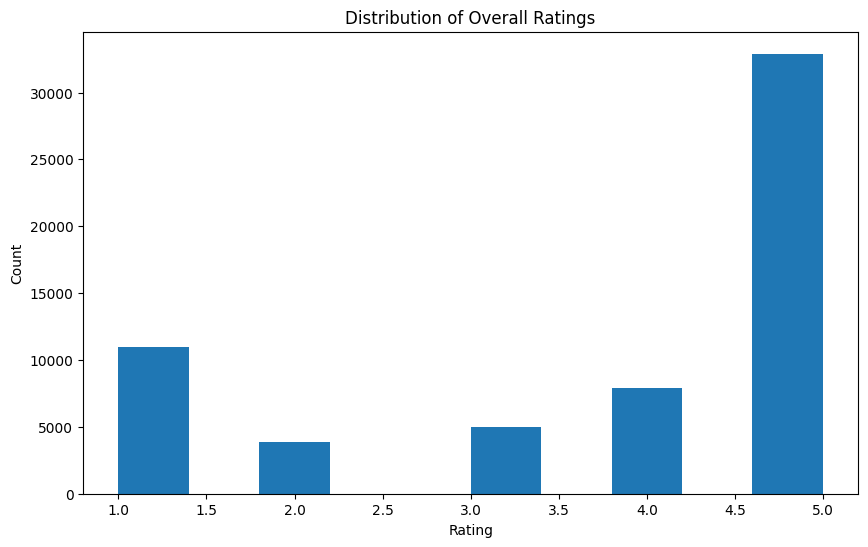

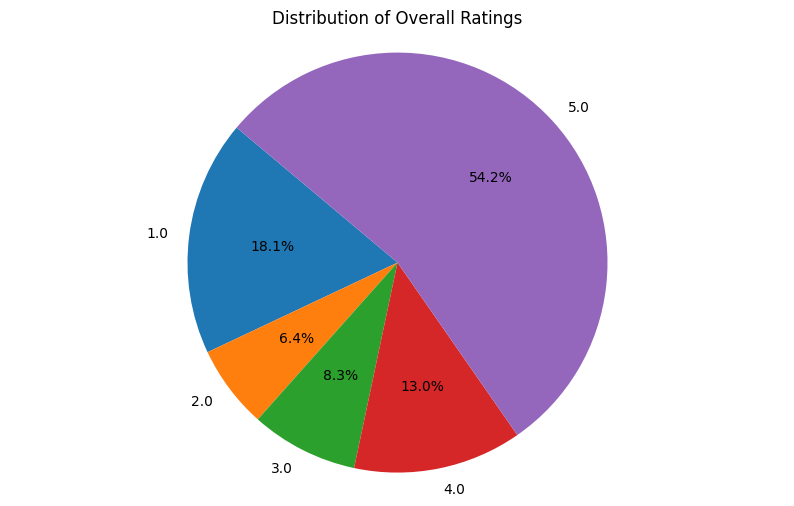

In [68]:


# Convert Spark DataFrame to Pandas for Visualization
pdf = df.toPandas()
reviews_per_asin_pdf = reviews_per_asin.toPandas()

# Histogram for overall ratings
plt.figure(figsize=(10, 6))
pdf['overall'].hist()
plt.title('Distribution of Overall Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.grid(False)
plt.show()

# Plotting the pie chart for overall ratings
rating_counts = pdf['overall'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
plt.pie(rating_counts, labels=rating_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Overall Ratings')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()




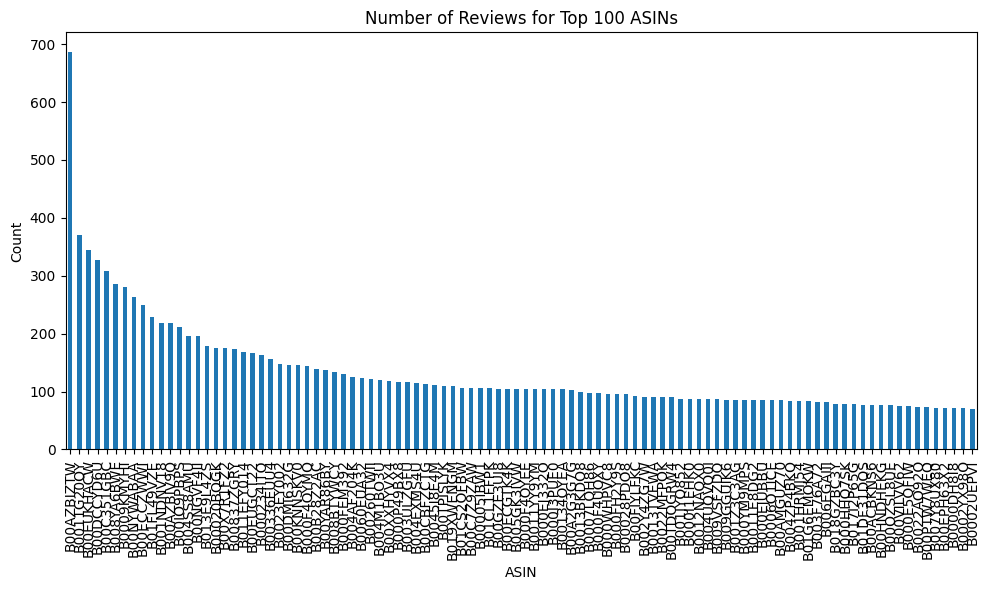

In [69]:

# Bar chart for number of reviews for each asin
top_reviews_per_asin_pdf = reviews_per_asin_pdf.sort_values(by='Number_of_Reviews', ascending=False).head(100)
plt.figure(figsize=(10, 6))
# Set the 'asin' as the index and plot the 'review_count' column
top_reviews_per_asin_pdf.set_index('asin')['Number_of_Reviews'].plot(kind='bar', legend=False)
plt.title('Number of Reviews for Top 100 ASINs')
plt.ylabel('Count')
plt.xlabel('ASIN')
plt.grid(False)
plt.tight_layout()
plt.show()

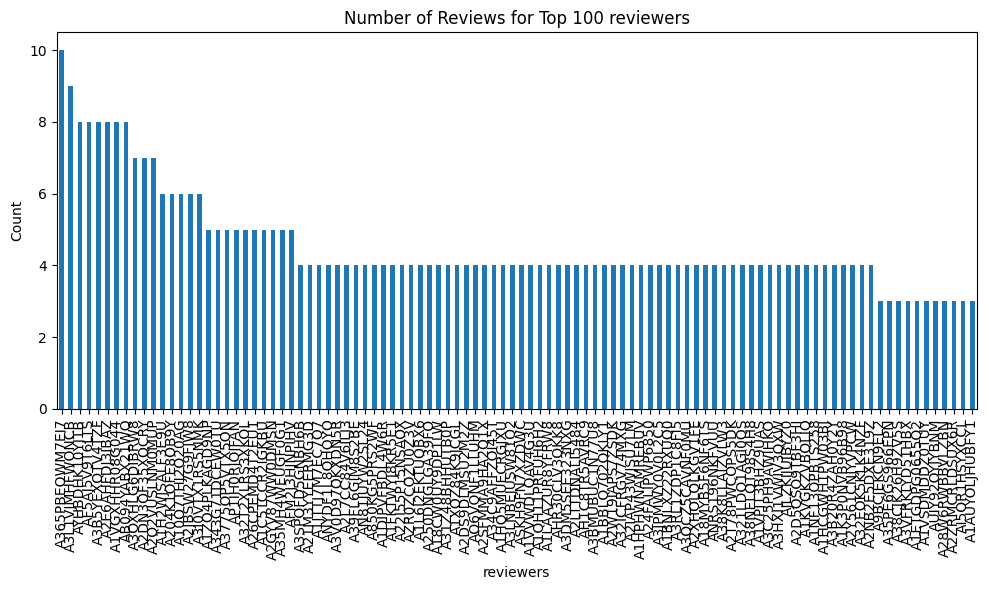

In [70]:
# Bar chart for number of reviews for each reviewers
reviews_per_reviewers_pdf = reviews_per_reviewers.toPandas()

top_reviews_per_reviewers_pdf = reviews_per_reviewers_pdf.sort_values(by='Number_of_Reviews', ascending=False).head(100)
plt.figure(figsize=(10, 6))
# Set the 'reviewers' as the index and plot the 'review_count' column
top_reviews_per_reviewers_pdf.set_index('reviewerID')['Number_of_Reviews'].plot(kind='bar', legend=False)
plt.title('Number of Reviews for Top 100 reviewers')
plt.ylabel('Count')
plt.xlabel('reviewers')
plt.grid(False)
plt.tight_layout()
plt.show()

In [71]:
# Convert reviewText and summary columns to a single string
review_text_str = ' '.join(df.rdd.map(lambda row: row.reviewText).collect())
summary_str = ' '.join(df.rdd.map(lambda row: row.summary).collect())

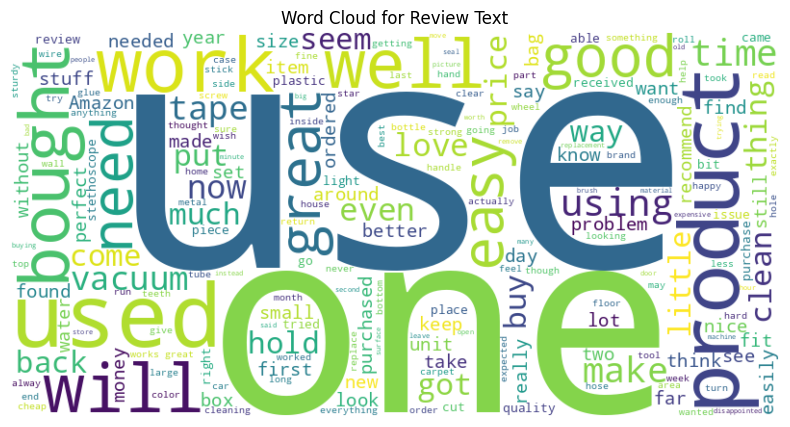

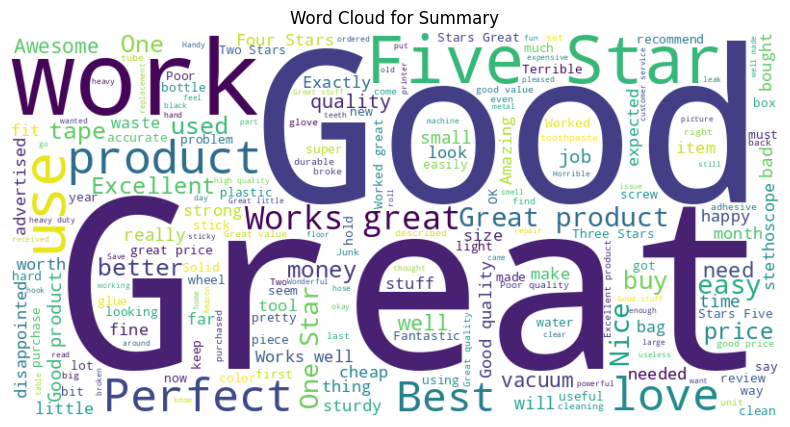

In [72]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_word_cloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

generate_word_cloud(review_text_str, "Word Cloud for Review Text")
generate_word_cloud(summary_str, "Word Cloud for Summary")


# Modelling

## Data Splitting

In [73]:

from pyspark.ml.feature import StringIndexer

# Indexing is required to convert string identifiers to numeric indices for the ALS algorithm
indexer_user = StringIndexer(inputCol="reviewerID", outputCol="userIndex")
df = indexer_user.fit(df).transform(df)

indexer_item = StringIndexer(inputCol="asin", outputCol="itemIndex")
df = indexer_item.fit(df).transform(df)

(train, test) = df.randomSplit([0.8, 0.2])


## ALS

refer: https://www.kaggle.com/code/nadianizam/h-m-fashion-recommendation-with-pyspark



In [74]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

# Setting up the ALS model
als = ALS(maxIter=5, regParam=0.01, userCol="userIndex", itemCol="itemIndex", ratingCol="overall", coldStartStrategy="drop")

# Fitting the ALS model on the training data
model = als.fit(train)

# Predicting on the train and test sets
predictions_train = model.transform(train)
predictions_test = model.transform(test)

# Create an RMSE evaluator using the label and predicted columns
reg_evaluator = RegressionEvaluator(metricName="rmse", labelCol="overall", predictionCol="prediction")

# Evaluate the model on training data
rmse_train = reg_evaluator.evaluate(predictions_train)

# Evaluate the model on test data
rmse_test = reg_evaluator.evaluate(predictions_test)


In [75]:
rmse_train

0.01939642624974559

In [76]:
rmse_test

3.1597927942487853

## GraphFrame

In [77]:
!pip install graphframes

In [78]:
from graphframes import GraphFrame

# Assuming 'df' is your original PySpark DataFrame and it has been indexed
# Create vertices DataFrame
vertices = df.selectExpr("userIndex as id").distinct().union(df.selectExpr("itemIndex as id").distinct()) # check if those two index overlap

# Create edges DataFrame
edges = df.selectExpr("userIndex as src", "itemIndex as dst", "overall as rating")

# Create a GraphFrame
graph = GraphFrame(vertices, edges)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


Py4JJavaError: ignored

In [ ]:
# TO DO
# 1: Hyperparameter tuning
# 2: How to make use of the graph functions?

# Content-based Filtering

In [84]:
df_meta = spark.read.json("meta_Industrial_and_Scientific.json.gz")

In [85]:
df_meta.groupBy('price').count().orderBy(col('count').desc()).show()

+--------------------+-----+
|               price|count|
+--------------------+-----+
|                    |42683|
|.a-box-inner{back...| 1064|
|               $9.99|  953|
|               $7.99|  793|
|               $8.99|  666|
|               $6.99|  650|
|              $14.99|  647|
|              $19.99|  639|
|              $12.99|  621|
|              $15.99|  518|
|              $11.99|  516|
|               $5.99|  515|
|               $1.41|  498|
|              $13.99|  482|
|               $9.95|  478|
|              $10.99|  467|
|               $4.99|  467|
|              $29.99|  449|
|              $16.99|  399|
|              $12.95|  365|
+--------------------+-----+
only showing top 20 rows



In [86]:
df_meta.groupBy('brand').count().orderBy(col('count').desc()).show()

+--------------------+-----+
|               brand|count|
+--------------------+-----+
|              uxcell| 7147|
|         Small Parts| 4252|
|   The Hillman Group| 1868|
|                    | 1302|
|           SmartSign| 1164|
|                  3M| 1021|
|                 VXB| 1003|
|               Brady|  866|
|     ComplianceSigns|  793|
|Hard-to-Find Fast...|  700|
|                SEOH|  680|
|   RAW PRODUCTS CORP|  660|
|           Fastenere|  608|
|             Generic|  582|
|              Vestil|  573|
|      D&D PowerDrive|  568|
|             Medline|  560|
|  Simpson Strong-Tie|  492|
|               EISCO|  487|
|             Hillman|  458|
+--------------------+-----+
only showing top 20 rows



In [90]:
from pyspark.sql.functions import regexp_replace
from pyspark.sql import functions as F
from pyspark.sql.functions import mean

# Replace null or empty strings with a placeholder
df_meta = df_meta.na.fill({"brand": "Unknown"})
df_meta = df_meta.withColumn("brand", F.when(F.col("brand") == "", "Unknown").otherwise(F.col("brand")))

# Step 1: Remove the dollar sign and try to convert the price to float
df_meta = df_meta.withColumn("price", regexp_replace(col("price"), "[\$,]", "").cast("float"))

# Step 2: Replace non-numeric (or negative) values with None, which Spark recognizes as null
df_meta = df_meta.withColumn("price", when(col("price") < 0, None).otherwise(col("price")))

# Step 3: Calculate the average of the numeric prices
average_price = df_meta.select(avg(col("price")).alias("avg_price")).collect()[0]["avg_price"]

# Step 4: Fill null values with the average price
df_meta = df_meta.na.fill({"price": average_price})


# Ensure the 'brand' column exists and does not have empty strings or null values
if 'brand' not in df_meta.columns:
    raise ValueError("'brand' column is missing from the DataFrame.")
if df_meta.filter((col('brand') == "") | (col('brand').isNull())).count() > 0:
    raise ValueError("'brand' column contains null or empty strings.")

# Ensure the 'price' column exists and has the correct data type
if 'price' not in df_meta.columns:
    raise ValueError("'price' column is missing from the DataFrame.")
if df_meta.filter(col('price').isNull()).count() > 0:
    df_meta = df_meta.fillna({'price': 0})  # Replace nulls with 0 in 'price' column

In [91]:
df_meta.select('brand').distinct().count()

24124

In [92]:
df_meta.groupBy('brand').count().orderBy(col('count').desc()).show()

+--------------------+-----+
|               brand|count|
+--------------------+-----+
|              uxcell| 7147|
|         Small Parts| 4252|
|   The Hillman Group| 1868|
|             Unknown| 1742|
|           SmartSign| 1164|
|                  3M| 1021|
|                 VXB| 1003|
|               Brady|  866|
|     ComplianceSigns|  793|
|Hard-to-Find Fast...|  700|
|                SEOH|  680|
|   RAW PRODUCTS CORP|  660|
|           Fastenere|  608|
|             Generic|  582|
|              Vestil|  573|
|      D&D PowerDrive|  568|
|             Medline|  560|
|  Simpson Strong-Tie|  492|
|               EISCO|  487|
|             Hillman|  458|
+--------------------+-----+
only showing top 20 rows



In [93]:
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder

# Convert the 'price' column into a vector column
assembler_for_price = VectorAssembler(inputCols=["price"], outputCol="price_vector")

# Normalize the price column
price_scaler = MinMaxScaler(inputCol="price_vector", outputCol="price_scaled")

# Indexing and one-hot encoding the brand
# brand_indexer = StringIndexer(inputCol='brand', outputCol='brand_index')
# brand_encoder = OneHotEncoder(inputCols=['brand_index'], outputCols=['brand_vec'])

# # Assemble all the features into one vector
# # Note: Now we're including 'brand_vec' and the output of the MinMaxScaler 'price_scaled'
# assembler_for_features = VectorAssembler(inputCols=['brand_vec', 'price_scaled'], outputCol="features")

# Define the pipeline with all the stages
pipeline = Pipeline(stages=[
    # brand_indexer,
    # brand_encoder,
    assembler_for_price,
    price_scaler
    # assembler_for_features
])

# After cleaning, try fitting the pipeline again
pipeline_model = pipeline.fit(df_meta)

# Now transform the data
df_transformed = pipeline_model.transform(df_meta)

# Show the result
df_transformed.show()



+--------------------+--------------------+----------+--------------------+--------------------+------------------+--------------------+-------+--------------------+---+--------------------+--------------------+--------------------+--------+--------------------+------------+--------------------+-----+--------------------+--------------------+--------------------+
|            also_buy|           also_view|      asin|               brand|            category|              date|         description|details|             feature|fit|            imageURL|     imageURLHighRes|            main_cat|   price|                rank|similar_item|               tech1|tech2|               title|        price_vector|        price_scaled|
+--------------------+--------------------+----------+--------------------+--------------------+------------------+--------------------+-------+--------------------+---+--------------------+--------------------+--------------------+--------+--------------------+------

In [94]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import Normalizer
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
import numpy as np

# Step 1: The item profiles are already in 'df_transformed' as 'features'

from pyspark.sql.functions import avg, count, collect_list
from pyspark.sql.window import Window

# Calculate the average price for each user
avg_price = df.join(df_transformed, 'asin').groupBy('reviewerID').agg(avg('price').alias('avg_price'))

# Count the occurrences of each brand for each user and find the most frequent one
brand_frequency = df.join(df_transformed, 'asin').groupBy('reviewerID', 'brand').agg(count('brand').alias('brand_count'))

# In case of ties, we will pick the brand with the maximum 'brand_count' or the first one alphabetically
windowSpec = Window.partitionBy('reviewerID').orderBy(col('brand_count').desc(), col('brand'))
top_brands = (brand_frequency.withColumn('rank', F.row_number().over(windowSpec))
              .where(col('rank') == 1)
              .select('reviewerID', 'brand'))

# Now join the average price and top brand for each user to create the user profile
user_profiles = avg_price.join(top_brands, 'reviewerID')

# Show the resulting user profiles
user_profiles.show()




+--------------------+------------------+--------------------+
|          reviewerID|         avg_price|               brand|
+--------------------+------------------+--------------------+
|A0006286D5ALV1QNJEM3|29.950000762939453|              Nutone|
|A0210779OEJL4ZVCZUBW|19.489999771118164|       BAFX Products|
|A03562378QEOPQCNIKHH| 94.98999786376953|              Goplus|
|A04051149NH0IDZZ4FH7|  29.6299991607666|                 ADC|
|A0472243D8I2DQPZ9P5M|              17.0|         Hydroplanet|
|A0565264GEWMT5I30L5K|29.989999771118164|              Abrams|
|A0575344WFZ4F94SHX4P| 59.06998825073242|                eSUN|
|A0705654XT5UCAYOY7TH|28.780000686645508|             Medline|
|A0746495A9PGBS6B7U4V|              37.0|Rubbermaid Commer...|
|A0883017SNDJO4MESB2E| 59.06998825073242|           JG AURORA|
|A0893983PA4VI8Y99OKC| 59.06998825073242|         Small Parts|
|A0928606NRR2AE4B4YZL| 59.06998825073242|           LOHAS-LED|
|      A10042M3XO3NET| 4.590000152587891|              

In [ ]:
from pyspark.sql.functions import col, expr
from pyspark.sql.types import ArrayType, FloatType, StructType, StructField

# Step 1: Prepare item profiles (assuming df_transformed contains 'asin', 'brand', and 'price' columns)
item_profiles = df_transformed.select('asin', 'brand', 'price')

# Step 2: User profiles are already prepared as 'user_profiles'

# For simplicity, let's create a UDF that calculates a simple similarity score
def calculate_similarity(user_brand, user_avg_price, item_brand, item_price):
    # Simple similarity based on brand matching and price difference
    brand_similarity = 1 if user_brand == item_brand else 0
    price_similarity = 1 - abs(item_price - user_avg_price) / user_avg_price
    # Combine the two components of similarity
    return brand_similarity * 0.5 + price_similarity * 0.5

# Register the UDF
similarity_udf = F.udf(calculate_similarity, FloatType())

# Assuming user_profiles has 'reviewerID', 'avg_price', and 'brand' columns
# and item_profiles has 'asin', 'brand', and 'price' columns

# Alias the DataFrames
user_profiles_alias = user_profiles.alias("up")
item_profiles_alias = item_profiles.alias("ip")

# Step 3: Calculate similarities for each user-item pair
# Cross-join user profiles with item profiles to calculate similarities
# This operation can be expensive; consider using a broadcast join if the item_profiles is small enough
user_item_similarity = (user_profiles_alias.crossJoin(item_profiles_alias)
                        .withColumn('similarity', similarity_udf(
                            col('up.brand'), col('up.avg_price'), col('ip.brand'), col('ip.price')))
                        .select('up.reviewerID', 'ip.asin', 'similarity'))

# Step 4: Generate Recommendations
# Exclude already reviewed items
df_already_reviewed = df.select('reviewerID', 'asin').alias("ar")
recommendations = (user_item_similarity.join(df_already_reviewed,
                                             (user_item_similarity.reviewerID == df_already_reviewed.reviewerID) &
                                             (user_item_similarity.asin == df_already_reviewed.asin), 'left_anti')
                   .groupBy('reviewerID')
                   .agg(expr('collect_list(struct(asin, similarity)) as recommendations')))
# ...


# Sort and get top N recommendations for each user
top_n = 10  # Assuming we want the top 10 recommendations
get_top_n = F.udf(lambda recs: sorted(recs, key=lambda x: x[1], reverse=True)[:top_n], ArrayType(StructType()))

final_recommendations = (recommendations
                         .withColumn('top_recommendations', get_top_n(col('recommendations')))
                         .select('reviewerID', 'top_recommendations'))

# Show the final recommendations
final_recommendations.show(truncate=False)
